# Libraries

In [1]:
# My library
import sarah1 as sa
# Basic libraries
import time
import numpy as np
import pandas as pd
# Data managements
import wfdb
# Statistics
from scipy import stats
import statistics as st
import statsmodels.api as sm
# Special functions
from statsmodels.graphics.tsaplots import plot_predict
from math import sqrt
# Plots
import matplotlib.pyplot as plt
# Widget
%matplotlib widget
# Theme
plt.style.use('ggplot')

# Read data

In [125]:
# Patient number
patient = "00"
# Define path to data
file = "/Users/jesus.fuentes/Developer/Data/LTAF_84P/" + patient
# Read data from binary files
data = wfdb.rdrecord(file)
# Assign ECG signals
ecgs = data.p_signal
# Determine the sampling frequency
f0 = data.fs
# Read only one ECG channel
ECG = ecgs[:, 0]
# Filter ECG signal via Butterworth
ECG = sa.filterECG(ECG, sampling_rate=f0)
# Open h5 file as pandas df
peak = pd.HDFStore('../LTAF_84P_stats/LTAF_84P-' + patient + '-t_width-60-peaks.h5')
# QRS complexes
rpeaks = []
for n in range( len(peak.keys()) ):
    rpeaks.append( peak['df' + str(n)]['R'] )
# Close file to free memory
peak.close()
# Sanitise peaks
nrpeak = [sa.removeNAN(rpeaks[n]) for n in range(len(rpeaks))]

## Anotations

In [ ]:
"""
label_store       symbol                                  description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13      Q                            Unclassifiable beat
14           14      ~                          Signal quality change
16           16      |                     Isolated QRS-like artifact
18           18      s                                      ST change
19           19      T                                  T-wave change
20           20      *                                        Systole
21           21      D                                       Diastole
22           22      "                             Comment annotation
23           23      =                         Measurement annotation
24           24      p                                    P-wave peak
25           25      B              Left or right bundle branch block
26           26      ^                      Non-conducted pacer spike
27           27      t                                    T-wave peak
28           28      +                                  Rhythm change
29           29      u                                    U-wave peak
30           30      ?                                       Learning
31           31      !                       Ventricular flutter wave
32           32      [      Start of ventricular flutter/fibrillation
33           33      ]        End of ventricular flutter/fibrillation
34           34      e                             Atrial escape beat
35           35      n                   Supraventricular escape beat
36           36      @  Link to external data (aux_note contains URL)
37           37      x             Non-conducted P-wave (blocked APB)
38           38      f                Fusion of paced and normal beat
39           39      (                                 Waveform onset
40           40      )                                   Waveform end
41           41      r       R-on-T premature ventricular contraction
"""

In [136]:
ann_atr = wfdb.rdann(file, 'atr', sampfrom=0, sampto=data.sig_len)
ann_qrs = wfdb.rdann(file, 'qrs', sampfrom=0, sampto=data.sig_len)
ATR = ann_atr.symbol
ATR = np.asarray(ATR)
QRS = ann_qrs.symbol
QRS = np.asarray(QRS)

In [149]:
np.save('symbols.dat', ATR)

In [147]:
np.where(ATR=='+')

(array([    0, 43340, 43434, 43438, 43915, 44232, 44497, 44766, 44792,
        44796, 44934, 44938, 44984, 44988, 45074, 45078, 45171, 45674,
        45679, 45684, 45792, 45798, 45980, 45985, 46022, 46026, 46040,
        46044, 46347, 46351, 46473, 46477, 47101, 47105, 47359, 47363,
        50266, 50270, 51854, 51858, 54456, 54460, 54555, 54559, 54675,
        54679, 55782, 55786, 56236, 56240, 56979, 56983, 57141, 57145,
        57614, 57620, 58164, 58169, 59102, 59106, 59171, 59175, 60477,
        60481, 60723, 60727, 61206, 61210, 61453, 61457, 61701, 61705,
        62323, 62327, 62379, 62384, 62639, 62643, 63648, 63653, 64297,
        64301, 64500, 64504, 65412, 65416, 65876, 65880, 66233]),)

In [148]:
np.where(QRS=='|')

(array([  734,   890,  3520,  3781,  8105, 10032, 35964, 36404, 36843,
        37512, 37513, 40357, 40440, 40569, 40570, 40571, 41339, 46249,
        47093, 47641, 47692, 48459, 48677, 48724, 50115, 50241, 51092,
        51242, 52711, 53143, 54419, 55628, 55702, 55703, 55708, 55718,
        55725, 55730, 55806, 56179, 57550, 58096, 59030, 59095, 59308,
        60085, 60096, 60395, 60396, 60465, 60755, 61105, 61115, 61116,
        61725, 62224, 62256, 62277, 62478, 62657, 62689, 63182, 63535,
        63859, 64179, 64392, 64400, 65085, 67603, 86261, 86265, 86266,
        86267, 86276, 86278, 86279, 87100, 87102, 90480, 90487, 90500,
        90782, 90926, 90957, 90959, 90961, 91176, 91230, 99993]),)

# HRV analysis

In [3]:
# Compute intervals between R-peaks
RRI = [np.ediff1d(nrpeak[n], to_begin=0) / f0 for n in range(len(nrpeak))]
for n in range(len(RRI)):
    RRI[n][0] = np.mean(RRI[n])
# Normal-Normal (HR) and HRV
HRI = [60/RRI[n] for n in range(len(RRI))]
HRV = [np.ediff1d(HRI[n], to_begin=0) for n in range(len(HRI))]
# Basic RR features
MRR = [st.mean(RRI[n]) for n in range(len(RRI))]
VRR = [st.variance(RRI[n]) for n in range(len(RRI))]
SDRR = np.sqrt(VRR)
# Basic HRV features
MHRV = [st.mean(HRV[n]) for n in range(len(HRV))]
VHRV = [st.variance(HRV[n]) for n in range(len(HRV))]
SDHRV = np.sqrt(VHRV)

## Plots

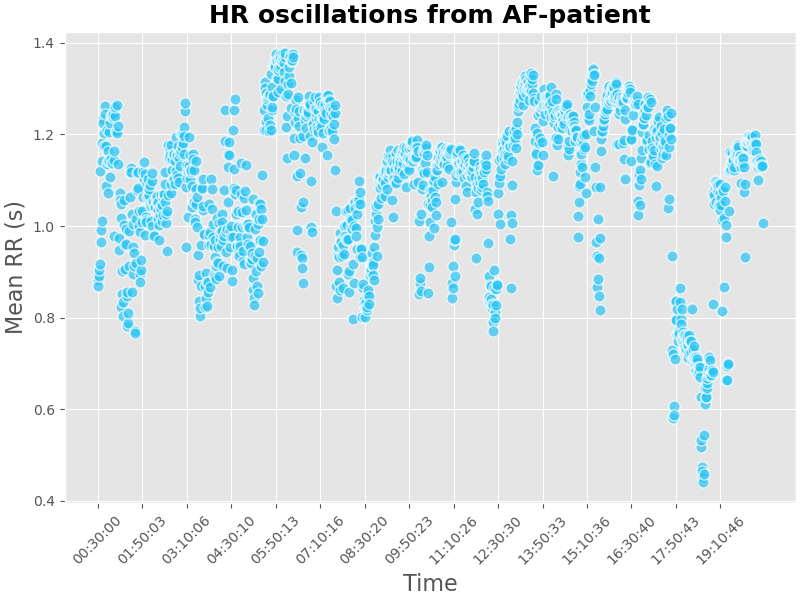

In [4]:
# Select HRV feature
feature = MRR
# The window is updated in intervals of:
winwidth = 50                  # seconds
start_at = 30*60               # seconds
# Raw time
tr = winwidth * np.linspace(0, len(feature), num=len(feature)) + start_at
# Time with format
tt = [time.strftime('%H:%M:%S', time.gmtime(tr[i])) for i in range(len(tr))]
# Define figure
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
# Call plots
plt.plot(tr, feature, 'o', color='#2AC5F4', mec='w', ms=8, alpha=0.7)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Mean RR (s)', fontsize=16)
plt.xticks(tr, labels=tt, rotation=45)
plt.title('HR oscillations from AF-patient', fontsize=18, weight='bold')
plt.locator_params(axis="x", nbins=15)
plt.show()

## Split data into chunks

    Only consider 80% of sample data

In [10]:
t0 = 800
window = 150
# Select a slice of data
endog = MRR[t0:t0+window]
nobs = len(endog)
tnobs = int(nobs * 0.8)
# Initialise pandas data frames
labs = pd.timedelta_range(start=(30*60+50*t0)*10**9, freq='50S', periods=window)
index = pd.date_range('1800-01-01', freq='AS', periods=window)
data = pd.DataFrame(endog, index=index)
data.columns = ['MRR']
# Split into train and test sets
train, test = data[:tnobs], data[tnobs:]

# SARIMAX model

In [11]:
mod301 = sm.tsa.statespace.SARIMAX(train, order=(3,0,3), trend='c').fit()
print(mod301.params)

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63707D+00    |proj g|=  1.70623D+00

At iterate    5    f= -1.63896D+00    |proj g|=  6.84042D-02

At iterate   10    f= -1.63947D+00    |proj g|=  4.35910D-01

At iterate   15    f= -1.63961D+00    |proj g|=  1.10057D-01

At iterate   20    f= -1.64159D+00    |proj g|=  1.21348D+00

At iterate   25    f= -1.64343D+00    |proj g|=  9.59855D-02

At iterate   30    f= -1.64353D+00    |proj g|=  6.09065D-02

At iterate   35    f= -1.64370D+00    |proj g|=  2.67586D-03

At iterate   40    f= -1.64371D+00    |proj g|=  9.19030D-03

At iterate   45    f= -1.64379D+00    |proj g|=  4.65182D-02

At iterate   50    f= -1.64380D+00    |proj g|=  3.96449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

## Prediction and forecasting

In [12]:
mod301.get_forecast().summary_frame()

MRR,mean,mean_se,mean_ci_lower,mean_ci_upper
1920-01-01,1.309524,0.046339,1.2187,1.400347


In [13]:
fore301 = mod301.get_forecast(nobs-tnobs)
pred301 = mod301.get_prediction()

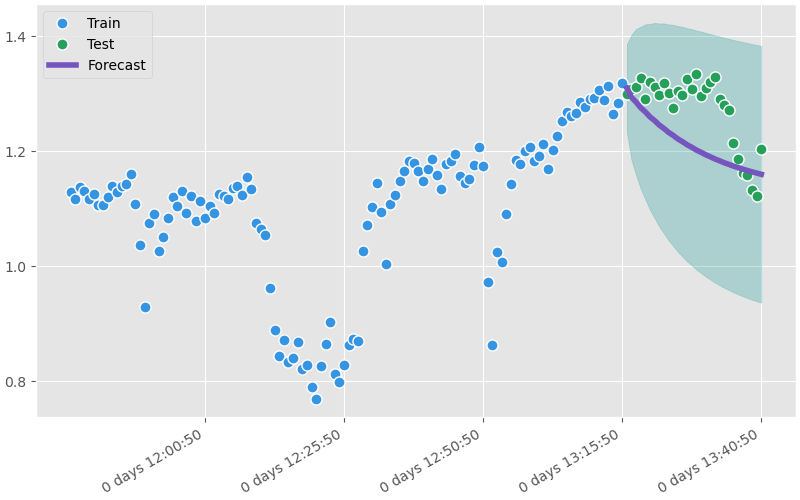

In [14]:
# Define figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
# Plot real data
plt.plot(train['MRR'], 'o', ms=8, mec='w', color='#3595E2', label='Train')
plt.plot(test['MRR'],  'o', ms=8, mec='w', color='#24A05A', label='Test')
#plt.plot(pred301, 'o', ms=8, mec='w', color='#A641A7', label='Prediction')
fore301.predicted_mean.plot(ax=ax, lw=4, color='#7655BE', label='Forecast')
f_conf = fore301.conf_int(alpha=0.10)
ax.fill_between(test.index, f_conf.iloc[:, 0], f_conf.iloc[:, 1], color='#02958E', alpha=0.25)
# Configure xticks
plt.xticks(index, labels=labs)
plt.locator_params(nbins=5)
ax.legend(loc='best')

## Cross validation

In [ ]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Create model for initial training sample, fit parameters
mod = sm.tsa.SARIMAX(train, order=(3, 0, 1), trend='c').fit()

# Save initial forecast
forecasts[train.index[-1]] = mod.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(tnobs, nobs):
    # Update the results by appending the next observation
    updated_endog = data.iloc[t: t + 1]
    mod = mod.append(updated_endog, refit=False)
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = mod.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

## Tests

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax = plt.plot(mod301.resid)
plt.xticks(index, labels=labs)
plt.locator_params(nbins=6)

print('Durbin-Watson: ', sm.stats.durbin_watson(mod301.resid))
print('Normal test: ', stats.normaltest(mod301.resid))

r, q, p = sm.tsa.acf(mod301.resid, nlags=tnobs, fft=True, qstat=True)
results = np.c_[r[1:], q, p]
table = pd.DataFrame(results,
                     columns=["AC", "Q", "Prob(>Q)"], 
                     index=pd.Index(range(1, q.shape[0] + 1), name="lag")
                    )

In [ ]:
from sklearn import metrics

In [ ]:
metrics.roc_curve(train['MRR'].values, table['Prob(>Q)'].values)